#### Human activity recognition feature representations with convolutional autoencoder

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [4]:
import torch
import os
import pandas as pd
import json

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR


import csv
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import sys
module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from frame_dataloader import WorkloadFrame
from convolutional_autoencoder import ConvAE
import utils

#### Cognitive/Physical workload Dataset

Input: consists of individual frames of length context_length * signal_length


In [8]:
# retrieve 1-second frames from csv 

b_size = 64
n_workers = utils.optimal_num_workers()

# directory to .mat files
dir='..\\files\\'

#  file group: 'phys', 'cog', or 'tot'
group='phys'

# signal channel to resample to: 'temp', 'hrv, 'hr', 'hbo', 'eda'
resample='temp'

# size of sliding window relative to shortest signal length; always 50% overlap between windows
context_length=0.5

frames = WorkloadFrame(dir=dir, group=group, resample=resample, context_length=context_length)

# split 'frames' dataset into train, val, and test
g = torch.Generator().manual_seed(7)

frames_trainset, frames_valset, frames_testset = random_split(frames, [0.8, 0.1, 0.1], generator=g)

frames_trainloader = DataLoader(frames_trainset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)
frames_valloader = DataLoader(frames_valset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)
frames_testloader = DataLoader(frames_testset, batch_size=b_size, num_workers=n_workers,pin_memory=torch.cuda.is_available(),persistent_workers=True, prefetch_factor=4)



Using 4 workers (CPU cores: 8, Available RAM: 1.85GB)


In [9]:
frames_trainset.__len__()

3047

In [10]:
frames_trainset.__getitem__(0)[0].shape

torch.Size([1, 5, 129])

#### Probing

In [22]:
# locate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_channels = 1
cout = 3

input_tensor = frames_trainset.__getitem__(0)[0].unsqueeze(0).to(device)


conv = nn.Conv2d(num_channels, cout, kernel_size=(3, 3), padding=(1, 1), device=device)
batchnorm = nn.BatchNorm2d(cout, device=device)

activation_map = conv(input_tensor)
n_activation_map = batchnorm(activation_map)

input_tensor.shape, activation_map.shape, n_activation_map.shape


(torch.Size([1, 1, 5, 129]),
 torch.Size([1, 3, 5, 129]),
 torch.Size([1, 3, 5, 129]))

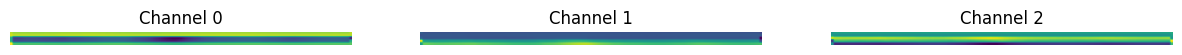

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(activation_map.cpu().detach().numpy()[0, i, :, :])
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")  

plt.show()

In [24]:
activation_map[0, 0, :, :]

tensor([[ -15.8935,  -35.2172,  -33.9146,  -34.8315,  -35.1869,  -34.7275,
          -35.5010,  -35.1993,  -35.1323,  -35.6149,  -35.0675,  -35.9079,
          -35.6139,  -33.1536,  -33.4540,  -34.2205,  -34.3674,  -34.2301,
          -32.7509,  -30.2770,  -30.2010,  -30.1902,  -29.7715,  -30.1736,
          -29.6348,  -30.0606,  -30.1935,  -28.9221,  -29.0505,  -28.8545,
          -28.8215,  -28.9958,  -28.4117,  -29.8608,  -30.3823,  -31.1400,
          -32.1157,  -31.5871,  -32.7816,  -33.2946,  -34.3118,  -35.4332,
          -34.4665,  -35.5002,  -36.5288,  -36.0917,  -37.2191,  -37.6684,
          -37.2323,  -38.0810,  -38.2334,  -37.1262,  -37.8418,  -38.2888,
          -36.9171,  -37.5723,  -38.2725,  -37.1764,  -35.9412,  -36.6345,
          -36.8824,  -35.4497,  -35.6416,  -36.2407,  -35.3252,  -33.2384,
          -33.1572,  -33.1979,  -31.3822,  -31.4095,  -31.5764,  -30.2171,
          -30.2093,  -30.4483,  -29.3121,  -29.4878,  -29.7241,  -28.7253,
          -28.6938,  -28.

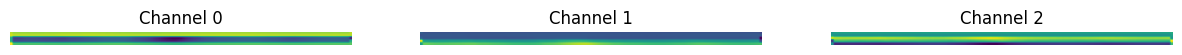

In [25]:
# batchnormed activation map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].imshow(n_activation_map.cpu().detach().numpy()[0, i, :, :])
    axes[i].set_title(f"Channel {i}")
    axes[i].axis("off")  

plt.show()

In [26]:
n_activation_map[0, 0, :, :]

tensor([[ 1.0008,  0.8550,  0.8649,  0.8580,  0.8553,  0.8587,  0.8529,  0.8552,
          0.8557,  0.8520,  0.8562,  0.8498,  0.8521,  0.8706,  0.8683,  0.8626,
          0.8615,  0.8625,  0.8736,  0.8923,  0.8929,  0.8930,  0.8961,  0.8931,
          0.8971,  0.8939,  0.8929,  0.9025,  0.9015,  0.9030,  0.9033,  0.9020,
          0.9064,  0.8954,  0.8915,  0.8858,  0.8784,  0.8824,  0.8734,  0.8695,
          0.8619,  0.8534,  0.8607,  0.8529,  0.8452,  0.8484,  0.8399,  0.8366,
          0.8398,  0.8334,  0.8323,  0.8406,  0.8353,  0.8319,  0.8422,  0.8373,
          0.8320,  0.8403,  0.8496,  0.8444,  0.8425,  0.8533,  0.8518,  0.8473,
          0.8542,  0.8700,  0.8706,  0.8703,  0.8840,  0.8838,  0.8825,  0.8927,
          0.8928,  0.8910,  0.8996,  0.8982,  0.8965,  0.9040,  0.9042,  0.9054,
          0.9085,  0.9069,  0.9093,  0.9032,  0.8925,  0.9012,  0.9013,  0.9036,
          0.9034,  0.9010,  0.9049,  0.9000,  0.8967,  0.8881,  0.8808,  0.8808,
          0.8748,  0.8741,  

In [27]:
# the batchnorm2d module normalizes each channel of activation map to have 0 mean and 1 standard deviation (e.g normalizes across W*H dimension)
torch.mean(n_activation_map[0, 0, :, :]), torch.std(n_activation_map[0, 0, :, :])

(tensor(-3.8443e-08, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0008, device='cuda:0', grad_fn=<StdBackward0>))

In [38]:
# reading existing logs for continous updating
df = pd.read_csv("..\\saved_models\\convolutional_autoencoder\\conv_ae_9374595.csv")
list(df.T.to_dict().values())

[{'Epoch': 1.0,
  'Training Loss': 1.0037,
  'Validation Loss': 1.0442,
  'Learning Rate': 0.001},
 {'Epoch': 2.0,
  'Training Loss': 0.9987,
  'Validation Loss': 1.0477,
  'Learning Rate': 0.001},
 {'Epoch': 3.0,
  'Training Loss': 0.9979,
  'Validation Loss': 1.0477,
  'Learning Rate': 0.001},
 {'Epoch': 4.0,
  'Training Loss': 0.9979,
  'Validation Loss': 1.0475,
  'Learning Rate': 0.001},
 {'Epoch': 5.0,
  'Training Loss': 0.9954,
  'Validation Loss': 1.0349,
  'Learning Rate': 0.001},
 {'Epoch': 6.0,
  'Training Loss': 0.9765,
  'Validation Loss': 1.0195,
  'Learning Rate': 0.001},
 {'Epoch': 7.0,
  'Training Loss': 0.9631,
  'Validation Loss': 0.9986,
  'Learning Rate': 0.001},
 {'Epoch': 8.0,
  'Training Loss': 0.9403,
  'Validation Loss': 0.9913,
  'Learning Rate': 0.001},
 {'Epoch': 9.0,
  'Training Loss': 0.9278,
  'Validation Loss': 0.9815,
  'Learning Rate': 0.001},
 {'Epoch': 10.0,
  'Training Loss': 0.9219,
  'Validation Loss': 0.9769,
  'Learning Rate': 0.001},
 {'Epoch'

#### Convolutional Autoencoder

In [ ]:
# TODO: make this stuff modular and less error prone (e.g resetting model parameters accidentally)

In [ ]:
# load model architecture

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dim=2084
c = [1, 64, 128, 256, 512]

conv_ae = ConvAE(latent_dim=dim, channels=c, kernel=(3, 3))
conv_ae.to(device)

model_filepath = "..\\saved_models\\convolutional_autoencoder\\"
model_name = f'conv_ae_{utils.num_parameters(conv_ae)}'

In [ ]:
# check for existing state dicts

if f'{model_name}.pth' in os.listdir(model_filepath):
    conv_ae.load_state_dict(torch.load(model_filepath+model_name+'.pth'))
else:
    print(f'No saved weights found for {model_name} in {model_filepath}')

In [ ]:
# check for existing logs

if f'{model_name}.csv' in os.listdir(model_filepath):
    df = pd.read_csv(model_filepath+model_name+'.csv')
    log = list(df.T.to_dict().values())
    print(f'Existing log data found for {len(log)} epochs')
else:
    log = []
    print(f'No existing log data found for {model_name} in {model_filepath}. Creating new one')

In [ ]:
# one time parameters

def loss_function(y, y_hat, red='mean'):
    return F.mse_loss(y, y_hat, reduction=red)

meta_data = {
    'model name':model_name,
    'learning rate':1e-3,
    'optimizer':'Adam',
    'latent dim': 2084,
    'channel sizes': c,
    'kernel size':(3, 3)
}

with open(model_filepath+model_name+'.json', 'w') as file:
    json.dump(meta_data, file, indent=4)

activation_stats = {}

def forward_hook(module, input, output):
    if conv_ae.log_stats:
        activation_stats[module] = {
            "mean": output.mean().item(),
            "std": output.std().item()
        }

for name, layer in conv_ae.named_modules(remove_duplicate=True):
    layer.register_forward_hook(forward_hook)

In [14]:
device, model_filepath, model_name

(device(type='cuda', index=0),
 '..\\saved_models\\convolutional_autoencoder\\',
 'conv_ae_9374595')

In [ ]:
# parameters tunable during training

epochs = 150
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0
optimizer = optim.Adam(conv_ae.parameters(), lr=1e-3)

step_lr = StepLR(optimizer, step_size=30, gamma=0.1)
cos_lr = CosineAnnealingLR(optimizer, T_max=epochs//10, eta_min=0)

scheduler = step_lr

#### Training Loop

In [ ]:
for e in range(epochs):
    conv_ae.train()
    train_loss = 0.0
    for data, _ in tqdm(frames_trainloader, desc=f"Epoch {e+1}/{epochs} [Training]", leave=False):
        data = data.to(device)

        optimizer.zero_grad()
        recon_data = conv_ae(data)
        loss = loss_function(recon_data, data, red='mean')
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    scheduler.step()

    conv_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in tqdm(frames_trainloader, desc=f"Epoch {e+1}/{epochs} [Validation]", leave=False):
            data = data.to(device)
            recon_data = conv_ae(data)
            loss = loss_function(recon_data, data, red='mean')

            val_loss += loss.item()

    # average losses
    train_loss /= len(frames_trainloader)
    val_loss /= len(frames_trainloader)

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    log.append({'Epoch':e+1, 'Training Loss':round(train_loss, 4), 'Validation Loss':round(val_loss, 4), 'Learning Rate':scheduler.get_last_lr()[0]})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(conv_ae.state_dict(), model_filepath + model_name + '.pth')
        loss_data = pd.DataFrame(log)
        loss_data.to_csv(model_filepath+model_name+'.csv', index=False)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        epochs_without_improvement = 0
        best_val_loss = 0.0
        print(f'Plateaued at {e+1}, switching to cosine annealing ')
        scheduler = cos_lr

torch.save(conv_ae.state_dict(), model_filepath + model_name + '.pth')
loss_data = pd.DataFrame(log)
loss_data.to_csv(model_filepath+model_name+'.csv', index=False)


Epoch 1/150 [Training]:   0%|          | 0/216 [00:00<?, ?it/s]

Epoch 1/150, Train Loss: 0.7998, Val Loss: 0.8729
Plateaued at 1, switching to cosine annealing 


Epoch 2/150, Train Loss: 0.7996, Val Loss: 0.8730


Epoch 3/150, Train Loss: 0.7994, Val Loss: 0.8736


Epoch 4/150, Train Loss: 0.7995, Val Loss: 0.8747


Epoch 5/150, Train Loss: 0.8004, Val Loss: 0.8749


Epoch 6/150, Train Loss: 0.8029, Val Loss: 0.8765


Epoch 7/150, Train Loss: 0.8056, Val Loss: 0.8791


Epoch 8/150, Train Loss: 0.8066, Val Loss: 0.8770


Epoch 9/150, Train Loss: 0.8061, Val Loss: 0.8755


Epoch 10/150, Train Loss: 0.8069, Val Loss: 0.8755


Epoch 11/150, Train Loss: 0.8071, Val Loss: 0.8821
Plateaued at 11, switching to cosine annealing 


Epoch 12/150, Train Loss: 0.8064, Val Loss: 0.8809


Epoch 13/150, Train Loss: 0.8061, Val Loss: 0.8763


Epoch 14/150, Train Loss: 0.8058, Val Loss: 0.8793


Epoch 15/150, Train Loss: 0.8052, Val Loss: 0.8783


Epoch 16/150, Train Loss: 0.8047, Val Loss: 0.8749


Epoch 17/150, Train Loss: 0.8029, Val Loss: 0.8749


Epoch 18/150, Train Loss: 0.8012, Val Loss: 0.8727


Epoch 19/150, Train Loss: 0.8003, Val Loss: 0.8734


Epoch 20/150, Train Loss: 0.7999, Val Loss: 0.8759


Epoch 21/150, Train Loss: 0.7996, Val Loss: 0.8755
Plateaued at 21, switching to cosine annealing 


Epoch 22/150, Train Loss: 0.7992, Val Loss: 0.8733


Epoch 23/150, Train Loss: 0.7990, Val Loss: 0.8735


Epoch 24/150, Train Loss: 0.7991, Val Loss: 0.8725


Epoch 25/150, Train Loss: 0.7991, Val Loss: 0.8723


Epoch 26/150, Train Loss: 0.7992, Val Loss: 0.8725


Epoch 27/150, Train Loss: 0.7990, Val Loss: 0.8725


Epoch 28/150, Train Loss: 0.7989, Val Loss: 0.8725


Epoch 29/150, Train Loss: 0.7987, Val Loss: 0.8722


Epoch 30/150, Train Loss: 0.7984, Val Loss: 0.8724


Epoch 31/150, Train Loss: 0.7982, Val Loss: 0.8730
Plateaued at 31, switching to cosine annealing 


Epoch 32/150, Train Loss: 0.7979, Val Loss: 0.8730


Epoch 33/150, Train Loss: 0.7978, Val Loss: 0.8736


Epoch 34/150, Train Loss: 0.7979, Val Loss: 0.8736


Epoch 35/150, Train Loss: 0.7986, Val Loss: 0.8749


Epoch 36/150, Train Loss: 0.8010, Val Loss: 0.8759


Epoch 37/150, Train Loss: 0.8037, Val Loss: 0.8765


Epoch 38/150, Train Loss: 0.8047, Val Loss: 0.8763


Epoch 39/150, Train Loss: 0.8042, Val Loss: 0.8744


Epoch 40/150, Train Loss: 0.8042, Val Loss: 0.8758


Epoch 41/150, Train Loss: 0.8040, Val Loss: 0.8795
Plateaued at 41, switching to cosine annealing 


Epoch 42/150, Train Loss: 0.8040, Val Loss: 0.8776


Epoch 43/150, Train Loss: 0.8034, Val Loss: 0.8763


Epoch 44/150, Train Loss: 0.8024, Val Loss: 0.8741


Epoch 45/150, Train Loss: 0.8015, Val Loss: 0.8727


Epoch 46/150, Train Loss: 0.8010, Val Loss: 0.8730


Epoch 47/150, Train Loss: 0.8005, Val Loss: 0.8729


Epoch 48/150, Train Loss: 0.8000, Val Loss: 0.8733


Epoch 49/150, Train Loss: 0.7993, Val Loss: 0.8737


Epoch 50/150, Train Loss: 0.7985, Val Loss: 0.8747


Epoch 51/150, Train Loss: 0.7979, Val Loss: 0.8737
Plateaued at 51, switching to cosine annealing 


Epoch 52/150, Train Loss: 0.7975, Val Loss: 0.8730


Epoch 53/150, Train Loss: 0.7974, Val Loss: 0.8733


Epoch 54/150, Train Loss: 0.7974, Val Loss: 0.8726


Epoch 55/150, Train Loss: 0.7976, Val Loss: 0.8724


Epoch 56/150, Train Loss: 0.7976, Val Loss: 0.8726


Epoch 57/150, Train Loss: 0.7975, Val Loss: 0.8727


Epoch 58/150, Train Loss: 0.7974, Val Loss: 0.8726


Epoch 59/150, Train Loss: 0.7972, Val Loss: 0.8723


Epoch 60/150, Train Loss: 0.7970, Val Loss: 0.8724


Epoch 61/150, Train Loss: 0.7967, Val Loss: 0.8728
Plateaued at 61, switching to cosine annealing 


Epoch 62/150, Train Loss: 0.7965, Val Loss: 0.8732


Epoch 63/150, Train Loss: 0.7964, Val Loss: 0.8734


Epoch 64/150, Train Loss: 0.7965, Val Loss: 0.8738


Epoch 65/150, Train Loss: 0.7973, Val Loss: 0.8743


Epoch 66/150, Train Loss: 0.7995, Val Loss: 0.8742


Epoch 67/150, Train Loss: 0.8020, Val Loss: 0.8761


Epoch 68/150, Train Loss: 0.8028, Val Loss: 0.8761


Epoch 69/150, Train Loss: 0.8026, Val Loss: 0.8763


Epoch 70/150, Train Loss: 0.8025, Val Loss: 0.8752


Epoch 71/150, Train Loss: 0.8030, Val Loss: 0.8765
Plateaued at 71, switching to cosine annealing 


Epoch 72/150, Train Loss: 0.8031, Val Loss: 0.8745


Epoch 73/150, Train Loss: 0.8029, Val Loss: 0.8776


Epoch 74/150, Train Loss: 0.8026, Val Loss: 0.8748


Epoch 75/150, Train Loss: 0.8015, Val Loss: 0.8751


Epoch 76/150, Train Loss: 0.8007, Val Loss: 0.8744


Epoch 77/150, Train Loss: 0.7990, Val Loss: 0.8739


Epoch 78/150, Train Loss: 0.7979, Val Loss: 0.8738


Epoch 79/150, Train Loss: 0.7972, Val Loss: 0.8734


Epoch 80/150, Train Loss: 0.7968, Val Loss: 0.8750


Epoch 81/150, Train Loss: 0.7966, Val Loss: 0.8732
Plateaued at 81, switching to cosine annealing 


Epoch 82/150, Train Loss: 0.7963, Val Loss: 0.8730


Epoch 83/150, Train Loss: 0.7963, Val Loss: 0.8732


Epoch 84/150, Train Loss: 0.7963, Val Loss: 0.8726


Epoch 85/150, Train Loss: 0.7964, Val Loss: 0.8727


Epoch 86/150, Train Loss: 0.7965, Val Loss: 0.8728


Epoch 87/150, Train Loss: 0.7964, Val Loss: 0.8728


Epoch 88/150, Train Loss: 0.7963, Val Loss: 0.8728


Epoch 89/150, Train Loss: 0.7961, Val Loss: 0.8725


Epoch 90/150, Train Loss: 0.7959, Val Loss: 0.8725


Epoch 91/150, Train Loss: 0.7956, Val Loss: 0.8729
Plateaued at 91, switching to cosine annealing 


Epoch 92/150, Train Loss: 0.7955, Val Loss: 0.8732


Epoch 93/150, Train Loss: 0.7954, Val Loss: 0.8735


Epoch 94/150, Train Loss: 0.7955, Val Loss: 0.8742


Epoch 95/150, Train Loss: 0.7962, Val Loss: 0.8741


Epoch 96/150, Train Loss: 0.7985, Val Loss: 0.8744


Epoch 97/150, Train Loss: 0.8008, Val Loss: 0.8758


Epoch 98/150, Train Loss: 0.8014, Val Loss: 0.8750


Epoch 99/150, Train Loss: 0.8013, Val Loss: 0.8751


Epoch 100/150, Train Loss: 0.8012, Val Loss: 0.8761


Epoch 101/150, Train Loss: 0.8010, Val Loss: 0.8772
Plateaued at 101, switching to cosine annealing 


Epoch 102/150, Train Loss: 0.8008, Val Loss: 0.8769


Epoch 103/150, Train Loss: 0.8008, Val Loss: 0.8751


Epoch 104/150, Train Loss: 0.8006, Val Loss: 0.8769


Epoch 105/150, Train Loss: 0.8001, Val Loss: 0.8749


Epoch 106/150, Train Loss: 0.7993, Val Loss: 0.8750


Epoch 107/150, Train Loss: 0.7981, Val Loss: 0.8735


Epoch 108/150, Train Loss: 0.7971, Val Loss: 0.8738


Epoch 109/150, Train Loss: 0.7964, Val Loss: 0.8743


Epoch 110/150, Train Loss: 0.7960, Val Loss: 0.8746


Epoch 111/150, Train Loss: 0.7957, Val Loss: 0.8725
Plateaued at 111, switching to cosine annealing 


Epoch 112/150, Train Loss: 0.7954, Val Loss: 0.8728


Epoch 113/150, Train Loss: 0.7954, Val Loss: 0.8731


Epoch 114/150, Train Loss: 0.7954, Val Loss: 0.8727


Epoch 115/150, Train Loss: 0.7955, Val Loss: 0.8726


Epoch 116/150, Train Loss: 0.7956, Val Loss: 0.8726


Epoch 117/150, Train Loss: 0.7955, Val Loss: 0.8726


Epoch 118/150, Train Loss: 0.7954, Val Loss: 0.8726


Epoch 119/150, Train Loss: 0.7952, Val Loss: 0.8724


Epoch 120/150, Train Loss: 0.7950, Val Loss: 0.8725


Epoch 121/150, Train Loss: 0.7948, Val Loss: 0.8727
Plateaued at 121, switching to cosine annealing 


Epoch 122/150, Train Loss: 0.7946, Val Loss: 0.8730


Epoch 123/150, Train Loss: 0.7945, Val Loss: 0.8732


Epoch 124/150, Train Loss: 0.7946, Val Loss: 0.8735


Epoch 125/150, Train Loss: 0.7954, Val Loss: 0.8742


Epoch 126/150, Train Loss: 0.7974, Val Loss: 0.8764


Epoch 127/150, Train Loss: 0.7997, Val Loss: 0.8743


Epoch 128/150, Train Loss: 0.7999, Val Loss: 0.8742


Epoch 129/150, Train Loss: 0.7995, Val Loss: 0.8738


Epoch 130/150, Train Loss: 0.7996, Val Loss: 0.8752


Epoch 131/150, Train Loss: 0.7997, Val Loss: 0.8737
Plateaued at 131, switching to cosine annealing 


Epoch 132/150, Train Loss: 0.8003, Val Loss: 0.8763


Epoch 133/150, Train Loss: 0.8006, Val Loss: 0.8747


Epoch 134/150, Train Loss: 0.8002, Val Loss: 0.8795


Epoch 135/150, Train Loss: 0.7996, Val Loss: 0.8741


Epoch 136/150, Train Loss: 0.7985, Val Loss: 0.8736


Epoch 137/150, Train Loss: 0.7975, Val Loss: 0.8727


Epoch 138/150, Train Loss: 0.7963, Val Loss: 0.8732


Epoch 139/150, Train Loss: 0.7955, Val Loss: 0.8735


Epoch 140/150, Train Loss: 0.7949, Val Loss: 0.8731


Epoch 141/150, Train Loss: 0.7947, Val Loss: 0.8727
Plateaued at 141, switching to cosine annealing 


Epoch 142/150, Train Loss: 0.7945, Val Loss: 0.8725


Epoch 143/150, Train Loss: 0.7945, Val Loss: 0.8728


Epoch 144/150, Train Loss: 0.7946, Val Loss: 0.8724


Epoch 145/150, Train Loss: 0.7947, Val Loss: 0.8721


Epoch 146/150, Train Loss: 0.7948, Val Loss: 0.8722


Epoch 147/150, Train Loss: 0.7947, Val Loss: 0.8722


Epoch 148/150, Train Loss: 0.7947, Val Loss: 0.8722


Epoch 149/150, Train Loss: 0.7945, Val Loss: 0.8721


Epoch 150/150, Train Loss: 0.7942, Val Loss: 0.8722


#### Model Parameters

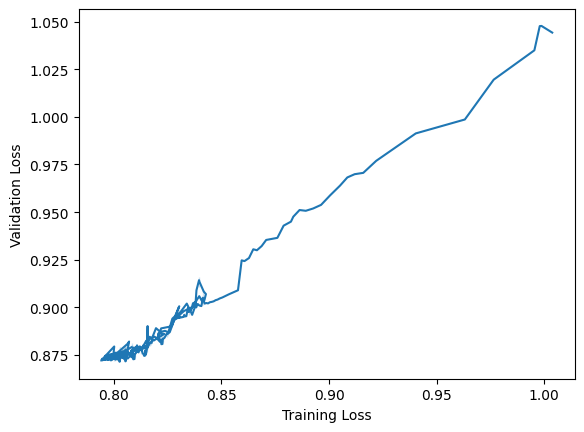

In [25]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x='Training Loss', y='Validation Loss', sort=False)
plt.show()

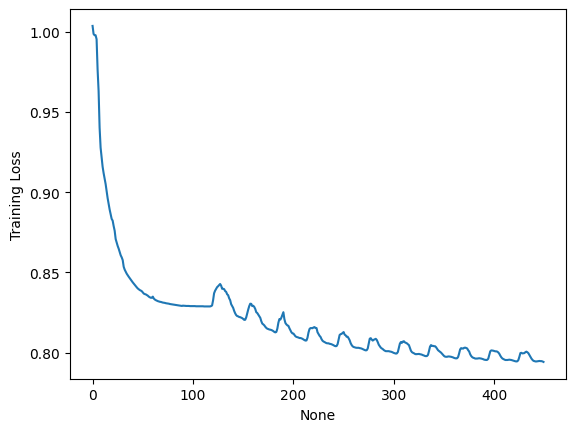

In [93]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Training Loss', sort=False)
plt.show()

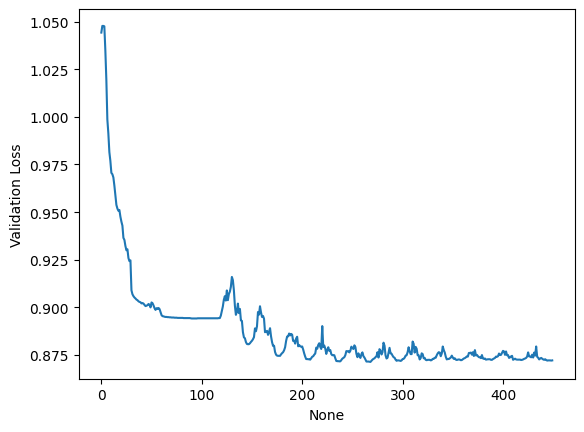

In [70]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Validation Loss', sort=False)
plt.show()

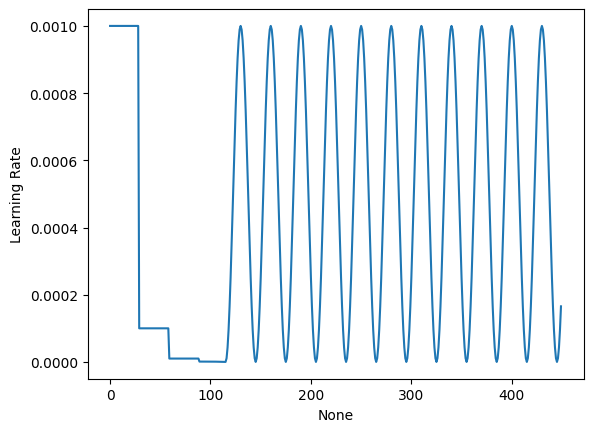

In [95]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Learning Rate', sort=False)
plt.show()

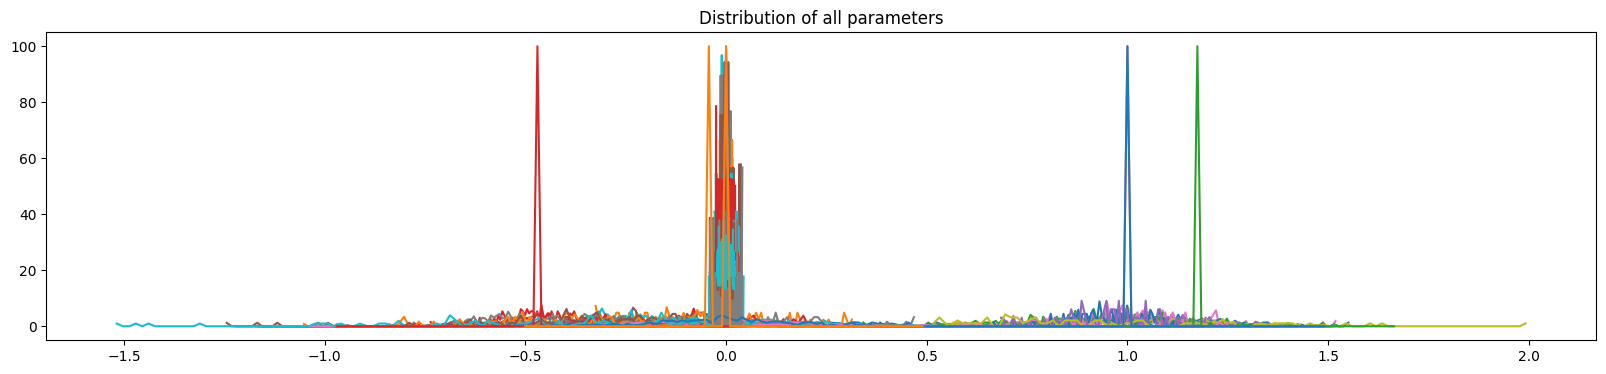

In [35]:
plt.figure(figsize=(20, 4)) # width and height of the plot

legends = []
for i, p in enumerate(conv_ae.parameters()):
    t = p.cpu()
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.title('Distribution of all parameters');

name: encoders.0.1.weight Shape: torch.Size([64]) Mean: 0.9452410936355591, Std: 0.2035362720489502, saturated: 45.3125
name: encoders.0.3.weight Shape: torch.Size([64, 64, 3, 3]) Mean: -0.045612554997205734, Std: 0.18910446763038635, saturated: 0.0244140625
name: encoders.0.4.weight Shape: torch.Size([64]) Mean: 1.0112602710723877, Std: 0.16021934151649475, saturated: 62.5
name: encoders.1.0.weight Shape: torch.Size([128, 64, 3, 3]) Mean: -0.027657732367515564, Std: 0.1868220567703247, saturated: 0.0162760429084301
name: encoders.1.1.weight Shape: torch.Size([128]) Mean: 1.0049285888671875, Std: 0.2616395950317383, saturated: 58.59375
name: encoders.1.3.weight Shape: torch.Size([128, 128, 3, 3]) Mean: -0.029480239376425743, Std: 0.18562838435173035, saturated: 0.0047471788711845875
name: encoders.1.4.weight Shape: torch.Size([128]) Mean: 1.0218780040740967, Std: 0.20032170414924622, saturated: 64.0625
name: encoders.2.0.weight Shape: torch.Size([256, 128, 3, 3]) Mean: -0.0230817515403

C:\Users\arthu\AppData\Local\Temp\ipykernel_17696\1795396973.py:5: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')


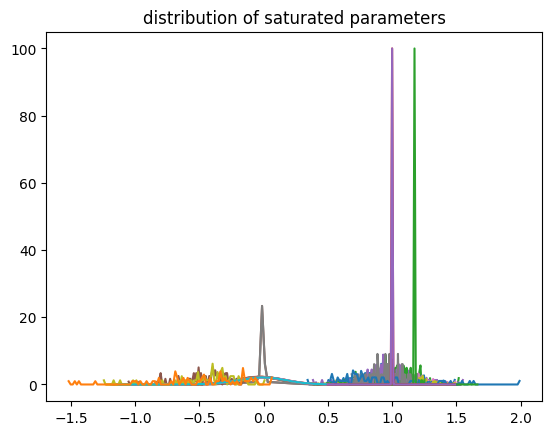

In [32]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if saturated > 0.0:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of saturated parameters');


name: encoders.0.3.bias Shape: torch.Size([64]) Mean: -0.0007204656139947474, Std: 0.02546939067542553, saturated: 0.0
name: encoders.1.0.bias Shape: torch.Size([128]) Mean: -0.0008669686503708363, Std: 0.024263866245746613, saturated: 0.0
name: encoders.1.3.bias Shape: torch.Size([128]) Mean: 0.0004742284945677966, Std: 0.016429468989372253, saturated: 0.0
name: encoders.2.0.bias Shape: torch.Size([256]) Mean: 0.0010626402217894793, Std: 0.01661694422364235, saturated: 0.0
name: encoders.2.3.bias Shape: torch.Size([256]) Mean: 0.0005392367020249367, Std: 0.012037165462970734, saturated: 0.0
name: encoders.3.0.bias Shape: torch.Size([512]) Mean: -0.00040216557681560516, Std: 0.011954276822507381, saturated: 0.0
name: encoders.3.3.bias Shape: torch.Size([512]) Mean: -0.0003983686910942197, Std: 0.008547928184270859, saturated: 0.0
name: decoders.0.0.bias Shape: torch.Size([512]) Mean: 0.00028421523165889084, Std: 0.008426968939602375, saturated: 0.0
name: decoders.0.3.bias Shape: torch.

C:\Users\arthu\AppData\Local\Temp\ipykernel_17696\2010225207.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  if t.std() < 0.05:


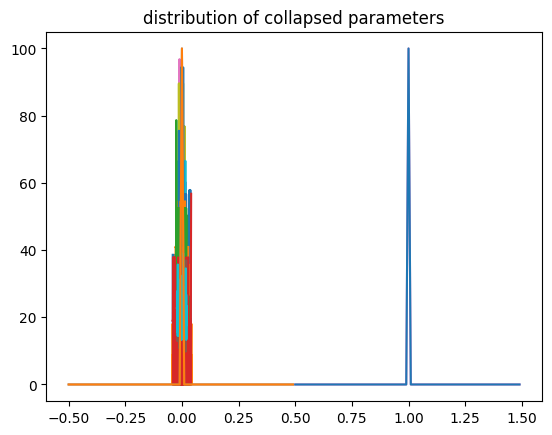

In [34]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if t.std() < 0.05:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of collapsed parameters');

In [37]:
sample_input = opportunity_trainset.__getitem__(0)[0].unsqueeze(0).to(device)
sample_input, sample_input.shape

(tensor([[[[-1.5155, -0.4009, -0.1012,  ...,  0.3109, -0.8955,  2.0122],
           [-1.5155, -0.5394, -0.0915,  ...,  0.2501, -0.4830,  1.9984],
           [-1.5154, -0.4808,  0.2521,  ..., -0.1522,  0.4073,  1.9984],
           ...,
           [-1.5134, -0.7739,  0.7506,  ..., -0.2493,  0.0933,  2.0122],
           [-1.5133, -0.5074,  0.3005,  ...,  0.1634,  0.2718,  2.0122],
           [-1.5132, -0.1025,  2.0282,  ...,  0.3226,  0.2620,  2.0122]]]],
        device='cuda:0'),
 torch.Size([1, 1, 30, 78]))

In [38]:
# set log_stats flag to true to log activation statistics for each module
conv_ae.log_stats = True
sample_output = conv_ae(sample_input)
conv_ae.log_stats = False
sample_output, sample_output.shape

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0203, 0.7918, 1.5633],
           [0.0000, 0.0000, 0.0000,  ..., 0.0225, 0.8764, 1.7303],
           [0.0000, 0.0000, 0.0000,  ..., 0.0246, 0.9609, 1.8973],
           ...,
           [0.0000, 0.3138, 0.6277,  ..., 0.0268, 1.0457, 2.0645],
           [0.0000, 0.3149, 0.6297,  ..., 0.0284, 1.1081, 2.1878],
           [0.0000, 0.3159, 0.6318,  ..., 0.0300, 1.1705, 2.3110]]]],
        device='cuda:0', grad_fn=<UpsampleBilinear2DBackward0>),
 torch.Size([1, 1, 30, 78]))

In [43]:
loss = loss_function(sample_input, sample_output, red='mean')
loss

tensor(0.7792, device='cuda:0', grad_fn=<MseLossBackward0>)

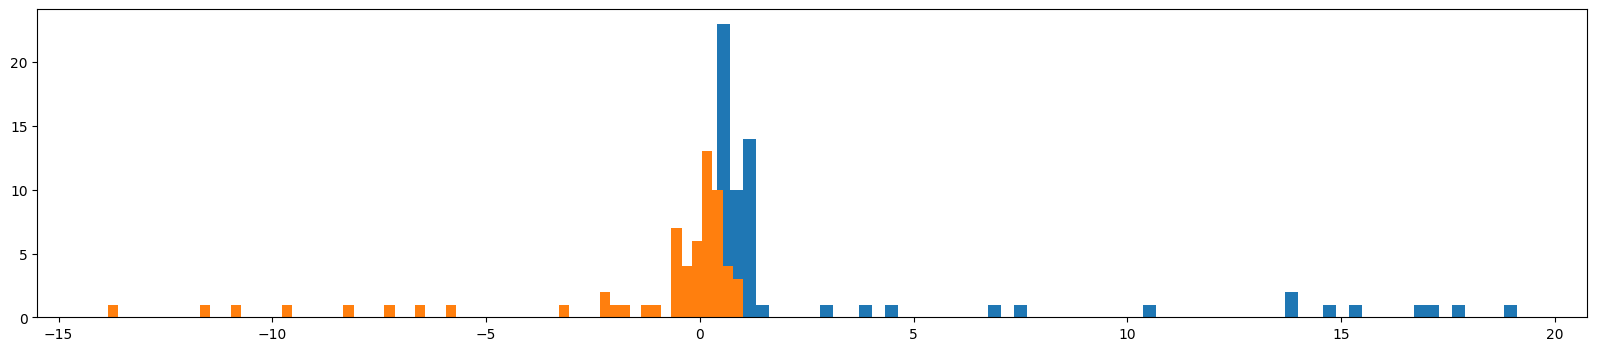

In [56]:
# accessing activation statistics saved to activation_stats by the forward hook
plt.figure(figsize=(20, 4))
s = []
m = []
for module, stats in activation_stats.items():
    s.append(stats['std'])
    m.append(stats['mean'])

plt.hist(s, len(s), label='Std of preactivations'); #  blue
plt.hist(m, len(m), label='Mean of preactivations'); # orange


In [ ]:
# load pretrained conv_ae

conv_ae_2 = ConvAE2d()
conv_ae_2.load_state_dict(torch.load('path_to_model/conv_ae.pth'))
conv_ae_2.eval()

# freeze all layers
for param in conv_ae.parameters():
    param.requires_grad = False  

# change last fc layers
num_features = conv_ae_2.fc.in_features
conv_ae_2.fc = nn.Linear(num_features, new_num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_ae_2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(conv_ae_2.fc.parameters(), lr=1e-3)  # only train last layer
criterion = nn.CrossEntropyLoss()
